# Pipeline de collecte des données

Le projet [Gallica Images](https://gallica.bnf.fr/accueil/fr/content/accueil-fr?mode=desktop) (2023-2026), qui à agréger et à indexer (à
l’aide de briques IA) les contenus iconographiques de Gallica sous la forme d’une base de
données publique dotée d’un moteur de recherche. Une des sources d’inspiration de ce
projet est le démonstrateur [GallicaPix](https://gallica.bnf.fr/blog/21062021/gallicapix-un-nouvel-outil-dexploration-iconographique?mode=desktop).

Ce stage s'inscrit dans la phase de sélection du partenaire industriel chargé des
développements informatiques et dans celle de la préparation du lancement du projet (été
2023). Il aura pour objet la conception et le développement d’un banc de test du pipeline de
traitement d’images qui sera produit par le partenaire industriel lors de l’année 1 du projet,
consacrée à la réalisation d’un MVP (minimum viable product) portant sur la collection Images de Gallica.
Ce banc de test servira à l’évaluation des performances du pipeline ainsi
qu’à sa recette finale.

Ce notebook a pour objectif la démonstration des différentes étapes du pipeline de l'entrepôt: de la collecte des métadonnées présent dans l'entrepôt OAINUM à la récupération des différentes images présent dans Gallica Images à travers le protocole IIIF. 

````{warning}
:class: dropdown
Ce jupyter est automatiquement chargé avec les modules et packages compris. Pour lancer le notebook localement, vous devez installer les packages requis. 
[Téléchargement](pipeline.zip)
````

## Les entrepôts de la BnF

La BnF gère deux types d'entrepôts OAI-NUM et OAI-CAT où sont stockés l'ensemble des métadonnées relatives à ses documents.

Le premier entrepôt OAI-NUM de données correspond aux notices des documents numériques dont la consultation est ouverte à tout public. Un sous-ensemble important de ces notices est consultable via Gallica en particulier. Cet entrepôt contient l’ensemble des notices des documents numériques consultables dans Gallica et pour lesquels la BnF possède les fichiers numériques. La granularité de cet entrepôt est le document numérique « unitaire », tel que consulté dans Gallica : un document numérique consultable identifié par un identifiant ark unique, un enregistrement (« record »).

Son interrogation permet d’obtenir les métadonnées d’un document numérique dont l’identifiant ark a par exemple été trouvé dans Gallica. Il est également possible d’obtenir une liste d’identifiants de documents appartenant à un ensemble prédéfini dans l’entrepôt (appelé « set » dans la terminologie OAI).

```{code-block} xml
:name: setsxml
:caption: Extrait XML de la requête [ListSets](http://oai.bnf.fr/oai2//OAIHandler?verb=ListSets) qui liste l'ensemble des sets présents dans l'entrepôt

<set>
<setSpec>gallica:typedoc:periodiques</setSpec>
<setName>Gallica : types de documents : périodiques imprimés</setName>
<setDescription>
<oai_dc:dc xmlns:oai_dc="http://www.openarchives.org/OAI/2.0/oai_dc/" xmlns:dc="http://purl.org/dc/elements/1.1/" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/oai_dc/ http://www.openarchives.org/OAI/2.0/oai_dc.xsd">
<dc:description xml:lang="fre">Cet ensemble donne accès aux journaux, revues et autres publications périodiques imprimées de Gallica.</dc:description>
<dc:description xml:lang="eng">This set provides access to the printed press, journals and serials in Gallica.</dc:description>
</oai_dc:dc>
</setDescription>
</set>
```


```{note}
:class: dropdown
L'arborescence des sets et analogue aux dossiers et sous-dossiers, dans l'exemple ci-dessus gallica est le le dossier racine et périodiques le dossier enfant de typedoc qui lui-même le dossier enfant de gallica.   
Cela permet de récupérer des ensembles de records disposant d'un parent commun.
```


### La collecte de métadonnées à travers `oai.py`

In [ ]:
!pip install -r modules/requirements.txt

In [1]:
from modules.oai import OAINUM
from fnmatch import fnmatch
from pprint import pprint
import os

In [2]:
#Créer une instance `gallica` et récupère l'ensemble des sets présents à l'intérieur de l'entrepôt
gallica = OAINUM('http://oai.bnf.fr/oai2//OAIHandler')
setspec,setname = gallica.listSets
len(setspec),setspec[250], setname[250]

(547, 'gallica:corpus:BNUStr059', 'Presse satirique alsacienne')

Il est également possible de récupérer les métadonnées associées à  des documents si on dispose de leur [ARK](https://www.bnf.fr/fr/lidentifiant-ark-archival-resource-key).Par défaut le type de format est le format **Dublin Core Simple** *oai_dc* mais il est également possible de récupérer le format **TEL-Application profile** *tel_ap*.

In [3]:
gallica.getRecord('btv1b6937398m')

{'title': ['[Estampes du recueil de costumes étrangers formé par M. de Gaignières, faisant suite aux costumes de france - Contrées du Nord - 1296 à 1577] : [estampe]'],
 'creator': [],
 'subject': ['Costume -- Écosse (GB)'],
 'description': ['Collectionneur : Gaignières, Roger de (1642-1715). Collectionneur'],
 'publisher': [],
 'contributor': [],
 'relation': ['Notice de recueil : http://catalogue.bnf.fr/ark:/12148/cb40356863k',
  'Appartient à : Recueil de costumes étrangers formé par M. de Gaignières, faisant suite aux costumes de france - Contrées du Nord - 1296 à 1577',
  'Notice du catalogue : http://catalogue.bnf.fr/ark:/12148/cb412591740'],
 'coverage': [],
 'identifier': ['http://gallica.bnf.fr/ark:/12148/btv1b6937398m'],
 'rights': ['domaine public'],
 'type': ['image fixe', 'estampe'],
 'language': [],
 'date': ['1600'],
 'format': ['35 gravures coloriées ; formats divers',
  'image/jpeg',
  'Nombre total de vues :  36'],
 'source': ['Bibliothèque nationale de France, départ

In [4]:
gallica.getRecord('btv1b6937398m',metadata='tel_ap')

{'identifier': ['http://gallica.bnf.fr/ark:/12148/btv1b6937398m/texteBrut'],
 'title': ['[Estampes du recueil de costumes étrangers formé par M. de Gaignières, faisant suite aux costumes de france - Contrées du Nord - 1296 à 1577] : [estampe]'],
 'alternativecontributor': [],
 'subject': ['Costume -- Écosse (GB)'],
 'description': ["Gravures insérées par R. de Gaignières dans l'album de dessins de costumes (p. 1-12, 20, 25-45, 47, 49)",
  'Après la page de titre, page manuscrite : "Table du XXe volume - Modes d\'Angleterre depuis 1296 jusqu\'en 1577 ; modes d\'Ecosse ; modes de Suède et de Laponie ; modes de Hongrie, modes de la Moscovie ; Modes de la Pologne et de la Prusse -N° 1461'],
 'typeOfResource': ['still image'],
 'type': ['Still image'],
 'extent': ['35 gravures coloriées'],
 'bibliographicCitation': ['[Estampes du recueil de costumes étrangers formé par M. de Gaignières, faisant suite aux costumes de france - Contrées du Nord - 1296 à 1577] : [estampe]. [1600]'],
 'date': ['

:::{important}

La BnF dipose de trois types de format de métadonnées dans l'entrepôt OAINUM:

1. **Dublin Cores Simple (oai_dc)** : les principes retenus à la BnF dans l’utilisation des éléments du Dublin Core simple sont présentés dans le [Guide d’utilisation du Dublin Core à la BnF](https://multimedia-ext.bnf.fr/pdf/guide_dublin_core_bnf_2008.pdf).

2. **TEL-Application profile (tel_ap)** : il s’agit d’un profil d’application du Dublin Core spécifiquement développé dans le cadre du projet européen The European Library. En plus des éléments du Dublin Core simple, le TEL – Application profile utilise quelques éléments du Dublin Code qualifié (ex. dcterms:issued), de MODS (ex. mods:location), et quelques éléments spécifiques à TEL-AP pour préciser le lien aux ressources numérisées lorsque c’est pertinent (tel:seeonline vers la ressource numérisée, et tel:fulltext vers le texte OCRisé).

3. **MPEG21-DIDL (didl)** : utile en particulier pour la représentation de la granularité des objets numériques (fascicules de périodiques, légendes des photographies dans un album). À l’intérieur de la structure DIDL, le format choisi est le Dublin Core simple.
:::

### Création d'un *parser*

L'instance `gallica` dispose seulement de l'implémentation du format `oai_dc` et `tel_ap` avec des *parser* par défaut. Il existe la possibilité de créer son propre parser notamment pour le format de métadonnées `didl` qui n'est pour lors pas implémenté.   

Le *parser* extrait seulement les balises et éléments enfants de `<metadata>`. Pour implémenter soi-même son propre parseur, il est nécessaire de créer un dictionnaire python qui comprend trois clés `fields`, `namespaces`, `prefix`, le premier étant le chemin [XPath](https://fr.wikipedia.org/wiki/XPath) de la donnée à extraire, le second étant l'ensemble des [namespaces](https://en.wikipedia.org/wiki/XML_namespace) nécessaire, ainsi que le préfixe obligatoire lors de la requête désignant un des trois type de format de métadonnées disponible dans l'entrepôt.  

Un exemple pour la [requête](http://oai.bnf.fr/oai2//OAIHandler?verb=GetRecord&identifier=oai:bnf.fr:gallica/ark:/12148/bpt6k5499065k&metadataPrefix=didl) concernant le document `ark`: [bpt6k5499065k](https://gallica.bnf.fr/ark:/12148/bpt6k5499065k) `prefix`: [DIDL](https://fr.wikipedia.org/wiki/MPEG-21):

::::{tab-set}
:::{tab-item} METADATA
```{code-block} xml
:name: metadataxml
:caption: Extrait XML des élements enfants de \<metadata\>
:linenos:
:emphasize-lines: 1,39
<metadata>
<didl:DIDL xmlns:didl="urn:mpeg:mpeg21:2002:02-DIDL-NS" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="urn:mpeg:mpeg21:2002:02-DIDL-NS http://standards.iso.org/ittf/PubliclyAvailableStandards/MPEG-21_schema_files/did/didl.xsd">
<didl:Item>
<didl:Descriptor>
<didl:Statement mimeType="text/xml; charset=UTF-8">
<dii:Identifier xmlns:dii="urn:mpeg:mpeg21:2002:01-DII-NS" xsi:schemaLocation="urn:mpeg:mpeg21:2002:01-DII-NS http://standards.iso.org/ittf/PubliclyAvailableStandards/MPEG-21_schema_files/dii/dii.xsd">http://gallica.bnf.fr/ark:/12148/bpt6k5499065k</dii:Identifier>
</didl:Statement>
</didl:Descriptor>
<didl:Descriptor>
<didl:Statement mimeType="text/xml; charset=UTF-8">
<oai_dc:dc xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:oai_dc="http://www.openarchives.org/OAI/2.0/oai_dc/" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/oai_dc/ http://www.openarchives.org/OAI/2.0/oai_dc.xsd">
<dc:identifier>http://gallica.bnf.fr/ark:/12148/bpt6k5499065k</dc:identifier>
<dc:title>Cour de cassation de Leipzig. Affaire de la réunion alsacienne de Mulhouse. Prévention d'association autorisée. Mémoire à consulter. Consultation. [Par J.-F. Dupont (de Bussac).]</dc:title>
<dc:creator>Dupont de Bussac, Jacques François (1803-1873). Auteur du texte</dc:creator>
<dc:contributor>Cour de cassation de Leipzig. Éditeur scientifique</dc:contributor>
<dc:publisher>impr. de Barthier (Paris)</dc:publisher>
<dc:date>1873</dc:date>
<dc:format>Gr. in-8° , 51 p.</dc:format>
<dc:language>fre</dc:language>
<dc:language>français</dc:language>
<dc:relation>Notice du catalogue : http://catalogue.bnf.fr/ark:/12148/cb303815454</dc:relation>
<dc:type xml:lang="eng">text</dc:type>
<dc:type xml:lang="fre">monographie imprimée</dc:type>
<dc:type xml:lang="eng">monographie imprimée</dc:type>
<dc:source>Bibliothèque nationale de France, département Philosophie, histoire, sciences de l'homme, 4-LB57-4383</dc:source>
<dc:rights xml:lang="fre">domaine public</dc:rights>
<dc:rights xml:lang="eng">public domain</dc:rights>
<dc:description>Appartient à l’ensemble documentaire : Alsace1</dc:description>
<dc:format>Nombre total de vues : 56</dc:format>
<dc:description>Avec mode texte</dc:description>
</oai_dc:dc>
</didl:Statement>
</didl:Descriptor>
<didl:Component>
<didl:Resource mimeType="application/pdf" ref="http://gallica.bnf.fr/ark:/12148/bpt6k5499065k"/>
</didl:Component>
</didl:Item>
</didl:DIDL>
</metadata>
```
:::
:::{tab-item} XML (Tree)
```{code-block} xml
:name: xmltreeoai
:caption: L'ensemble de l'arborescence XML
:linenos:
:emphasize-lines: 13,51
<OAI-PMH xmlns="http://www.openarchives.org/OAI/2.0/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/ http://www.openarchives.org/OAI/2.0/OAI-PMH.xsd">
<responseDate>2023-06-05T09:34:20Z</responseDate>
<request verb="GetRecord" identifier="oai:bnf.fr:gallica/ark:/12148/bpt6k5499065k" metadataPrefix="didl">http://oai.bnf.fr/oai2//OAIHandler</request>
<GetRecord>
<record>
<header>
<identifier>oai:bnf.fr:gallica/ark:/12148/bpt6k5499065k</identifier>
<datestamp>2018-04-26</datestamp>
<setSpec>gallica:corpus:Alsace1</setSpec>
<setSpec>gallica:theme:9:94</setSpec>
<setSpec>gallica:typedoc:monographies</setSpec>
</header>
<metadata>
<didl:DIDL xmlns:didl="urn:mpeg:mpeg21:2002:02-DIDL-NS" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="urn:mpeg:mpeg21:2002:02-DIDL-NS http://standards.iso.org/ittf/PubliclyAvailableStandards/MPEG-21_schema_files/did/didl.xsd">
<didl:Item>
<didl:Descriptor>
<didl:Statement mimeType="text/xml; charset=UTF-8">
<dii:Identifier xmlns:dii="urn:mpeg:mpeg21:2002:01-DII-NS" xsi:schemaLocation="urn:mpeg:mpeg21:2002:01-DII-NS http://standards.iso.org/ittf/PubliclyAvailableStandards/MPEG-21_schema_files/dii/dii.xsd">http://gallica.bnf.fr/ark:/12148/bpt6k5499065k</dii:Identifier>
</didl:Statement>
</didl:Descriptor>
<didl:Descriptor>
<didl:Statement mimeType="text/xml; charset=UTF-8">
<oai_dc:dc xmlns:dc="http://purl.org/dc/elements/1.1/" xmlns:oai_dc="http://www.openarchives.org/OAI/2.0/oai_dc/" xsi:schemaLocation="http://www.openarchives.org/OAI/2.0/oai_dc/ http://www.openarchives.org/OAI/2.0/oai_dc.xsd">
<dc:identifier>http://gallica.bnf.fr/ark:/12148/bpt6k5499065k</dc:identifier>
<dc:title>Cour de cassation de Leipzig. Affaire de la réunion alsacienne de Mulhouse. Prévention d'association autorisée. Mémoire à consulter. Consultation. [Par J.-F. Dupont (de Bussac).]</dc:title>
<dc:creator>Dupont de Bussac, Jacques François (1803-1873). Auteur du texte</dc:creator>
<dc:contributor>Cour de cassation de Leipzig. Éditeur scientifique</dc:contributor>
<dc:publisher>impr. de Barthier (Paris)</dc:publisher>
<dc:date>1873</dc:date>
<dc:format>Gr. in-8° , 51 p.</dc:format>
<dc:language>fre</dc:language>
<dc:language>français</dc:language>
<dc:relation>Notice du catalogue : http://catalogue.bnf.fr/ark:/12148/cb303815454</dc:relation>
<dc:type xml:lang="eng">text</dc:type>
<dc:type xml:lang="fre">monographie imprimée</dc:type>
<dc:type xml:lang="eng">monographie imprimée</dc:type>
<dc:source>Bibliothèque nationale de France, département Philosophie, histoire, sciences de l'homme, 4-LB57-4383</dc:source>
<dc:rights xml:lang="fre">domaine public</dc:rights>
<dc:rights xml:lang="eng">public domain</dc:rights>
<dc:description>Appartient à l’ensemble documentaire : Alsace1</dc:description>
<dc:format>Nombre total de vues : 56</dc:format>
<dc:description>Avec mode texte</dc:description>
</oai_dc:dc>
</didl:Statement>
</didl:Descriptor>
<didl:Component>
<didl:Resource mimeType="application/pdf" ref="http://gallica.bnf.fr/ark:/12148/bpt6k5499065k"/>
</didl:Component>
</didl:Item>
</didl:DIDL>
</metadata>
</record>
</GetRecord>
</OAI-PMH>
```
:::
:::{tab-item} OAI_DC (default)
```{code-block} python
:name: oaidcparser
:caption: Parser par défaut implémenter pour oai_dc
  fields={
    'title':       ('textList', 'oai_dc:dc/dc:title/text()'),
    'creator':     ('textList', 'oai_dc:dc/dc:creator/text()'),
    'subject':     ('textList', 'oai_dc:dc/dc:subject/text()'),
    'description': ('textList', 'oai_dc:dc/dc:description/text()'),
    'publisher':   ('textList', 'oai_dc:dc/dc:publisher/text()'),
    'contributor': ('textList', 'oai_dc:dc/dc:contributor/text()'),
    'relation':    ('textList', 'oai_dc:dc/dc:relation/text()'),
    'coverage':    ('textList', 'oai_dc:dc/dc:coverage/text()'),
    'identifier':  ('textList', 'oai_dc:dc/dc:identifier/text()'),
    'rights':      ('textList', 'oai_dc:dc/dc:rights[@xml:lang="fre"]/text()'),
    'type':        ('textList', 'oai_dc:dc/dc:type[@xml:lang="fre"]/text()'),
    'language':    ('textList', 'oai_dc:dc/dc:language/text()'),
    'date':        ('textList', 'oai_dc:dc/dc:date/text()'),
    'format':      ('textList', 'oai_dc:dc/dc:format/text()'),
    'source':      ('textList', 'oai_dc:dc/dc:source/text()'),},
namespaces={
    'oai_dc': 'http://www.openarchives.org/OAI/2.0/oai_dc/',
    'dc' : 'http://purl.org/dc/elements/1.1/'}
```
:::
:::{tab-item} TEL_AP (default)
```{code-block} python
:name: telapparser
:caption: Parser par défaut implémenter pour tel_ap
 fields={ 
    'identifier': ('textList', 'telap:record/tel:fullText/text()'),
    'title': ('textList', 'telap:record/dc:title/text()'),
    'alternative'
    'contributor': ('textList', 'telap:record/dc:contributor/text()'),
    'subject': ('textList', 'telap:record/dc:subject/text()'),
    'description': ('textList', 'telap:record/dc:description/text()'),
    'typeOfResource': ('textList', 'telap:record/mods:typeOfResource/text()'),
    'type': ('textList', 'telap:record/dc:type/text()'),
    'extent': ('textList', 'telap:record/dcterms:extent/text()'),
    'bibliographicCitation': ('textList', 'telap:record/dcterms:bibliographicCitation/text()'),
    'date': ('textList', 'telap:record/dc:date/text()'),
    'format': ('textList', 'telap:record/dc:format/text()'),
    'source': ('textList', 'telap:record/dc:source/text()'),
    'location': ('textList', 'telap:record/mods:location/text()'),
    'isFormatOf': ('textList', 'telap:record/dcterms:isFormatOf/text()'),
    'seeOnline': ('textList', 'telap:record/tel:seeOnline/text()'),
    'fullText': ('textList', 'telap:record/tel:fullText/text()'),},    
namespaces={
    'telap':'http://catalogue.bnf.fr/namespaces/TEL_ApplicationProfile',
    'dc' : 'http://purl.org/dc/elements/1.1/',
    'mods': 'http://www.loc.gov/mods',
    'dcterms': 'http://purl.org/dc/terms/',
    'tel': 'http://krait.kb.nl/coop/tel/handbook/telterms.html'}
```
:::
::::

In [5]:
didl = {
    'fields':{
        'source': ('textList', 'didl:DIDL/didl:Item/didl:Descriptor/didl:Statement/oai_dc:dc/dc:source/text()')},
    'namespaces': {
        'didl':'urn:mpeg:mpeg21:2002:02-DIDL-NS',
        'dii': '"urn:mpeg:mpeg21:2002:01-DII-NS',
        'oai_dc': 'http://www.openarchives.org/OAI/2.0/oai_dc/',
        'dc':'http://purl.org/dc/elements/1.1/'},
    'prefix': 'didl'
}

gallica.getRecord('bpt6k5499065k',metadata=didl)

{'source': ["Bibliothèque nationale de France, département Philosophie, histoire, sciences de l'homme, 4-LB57-4383"]}

(chunksize_research)=
### Collecte de sets présent dans l'entrepôt
Le téléchargement d'un set, c'est-à-dire d'une collection disponible dans l'entrepôt, se fait de manière séquentielle. Lors d'une requête, les records nous sont envoyés par lots. La première requête nous retourne également un `resumptionToken` qui nous permet de lancer une deuxième requête à laquelle le `resumptionToken` sera attaché. Cela nous permet, requête par requête, *(page par page)* de collecter l'ensemble des records. Il nous indique également le nombre de records présents pour cette collection.

```{code-block} xml
:name: tokenoai
:caption: Exemple de resumptionToken pour une collection (141542 records)
<resumptionToken expirationDate="2023-06-05T11:07:26Z" completeListSize="141542" cursor="0">93!8!68469958!6018!100!141542!oai_dc</resumptionToken>
```

Il est également important de noter que lors de l'appel de la fonction `pullSets()` il est possible de préciser la taille maximale d'un fichier`.json` lors de l'écriture des records. Par défaut, celui-ci est fixé à `20mb`, pour des grosses collections. Il est possible d'augmenter la taille maximum, mais il n'est généralement pas recommandé de descendre en dessous.

In [6]:
'''
Par défaut, l'ensemble des sets sont téléchargés dans un dossier`./data/json` qui comprendra l'ensemble des sous-dossiers correspondant aux différents sets.
Il est possible de changer de chemin lors de l'instanciation de la classe (si le dossier n'existe pas, celui-ci sera créé automatiquement.)
'''
dir_ = './data/sets/'
gallica = OAINUM('http://oai.bnf.fr/oai2//OAIHandler',directory=dir_)
#sets_str = ['gallica:corpus:BNUStr059', 'gallica:corpus:EnPCcorp18']
sets = [setspec[250],setspec[290]]
sets

['gallica:corpus:BNUStr059', 'gallica:corpus:EnPCcorp15']

In [7]:
gallica.pullSets(*sets,mb=20)

Lors du téléchargement d'une collection un fichier `.log` est créé, celui-ci indique les records qui n'ont pas pu être récupérés, car supprimé de l'entrepôt. En effet, certains records sont supprimés avec leur métadonnée, même si leurs identifiants persistent.

In [8]:
pathfinder_log = lambda directory: [os.path.join(dirpath,file) for dirpath,_,files in os.walk(dir_) 
                                    for file in files if fnmatch(file,f'*.log')]
logs = pathfinder_log(dir_)
if logs:
    with open(logs[0], 'r') as log:
        print(log.readline())    

[2023-06-11 14:14:49] - INFO | ark:/12148/cb328036848/date est suprimmé du dépôt ['gallica:corpus:BNUStr059', 'gallica:theme:0:00', 'gallica:typedoc:periodiques:titres']



```{image} assets/gallica-images-docnotfind.png
:alt: document introuvable sur gallica
:width: 900px
:align: center
```

### Collecte des images à travers `document.py`

`document.py` est une classe qui permet de récupérer les métadonnées d'un document, et de télécharger les images associées sous les *form* IIIF.

In [9]:
import nest_asyncio
nest_asyncio.apply()
'''
De par sa conception, asyncio n'autorise pas l'imbrication de sa boucle d'événements. 
Cela présente un problème pratique : dans un environnement où la boucle d'événements est déjà en cours d'exécution, 
il est impossible d'exécuter des tâches et d'attendre le résultat. 
Essayer de le faire donnera l'erreur "RuntimeError : Cette boucle d'événements est déjà en cours d'exécution".
Le problème apparaît dans divers environnements, tels que les serveurs Web, les applications graphiques et les blocs-notes Jupyter.
Ce module corrige asyncio pour permettre l'utilisation imbriquée de asyncio.run et loop.run_until_complete
Note: seulement nécessaire à l'intérieur d'un jupyterbook
'''
from modules.record import Document
import matplotlib.pyplot  as plt
import skimage

In [10]:
#La possibilité de récupérer les métadonnées sous le format 'oai_dc' est avec le parseur par défaut
doc = Document('btv1b9077367m')
doc.metadata

{'title': ['[Recueil. Les évènements du 06 février 1934] : [lot de photographies de presse] / [Agence Meurisse]'],
 'creator': ['Agence de presse Meurisse. Agence photographique (commanditaire)'],
 'subject': ['France -- 1934 (Manifestation du 6 février)'],
 'description': ['Image de presse'],
 'publisher': ['[Agence Meurisse] (Paris)'],
 'contributor': [],
 'relation': ['Notice du catalogue : http://catalogue.bnf.fr/ark:/12148/cb42479434g'],
 'coverage': ['06 février 1934'],
 'identifier': ['http://gallica.bnf.fr/ark:/12148/btv1b9077367m'],
 'rights': ['domaine public'],
 'type': ['image fixe', 'photographie'],
 'language': ['fre'],
 'date': ['1934'],
 'format': ['27 photogr. nég. sur verre : n. et b.',
  'image/jpeg',
  'Nombre total de vues :  27'],
 'source': ['Bibliothèque nationale de France, département Estampes et photographie, EI-13']}

In [11]:
#La possibilité également de récupérer toutes les images correspondant à ce document
doc.images

['https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f1/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f2/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f3/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f4/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f5/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f6/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f7/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f8/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f9/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f10/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f11/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/btv1b9077367m/f12/full/full/0/native.jpg',
 

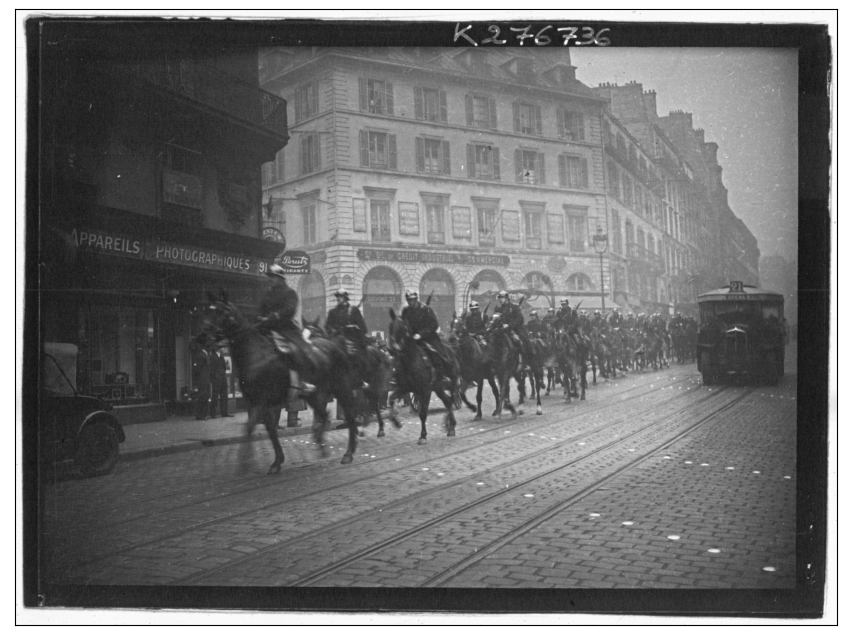

In [12]:
img = skimage.io.imread(doc.images[22])
img_rgb = skimage.color.gray2rgb(img)
plt.figure(figsize=(15, 8))
plt.imshow(img_rgb)
plt.xticks([])
plt.yticks([]);

Il est possible de télécharger les images correspondant au document de façon asynchrone. Des limitations surviennent pendant l'utilisation de l'API [IIIF](https://iiif.io/) de la BnF *(hors serveur interne à la BnF)*. Un algorithme de [seau percé](https://fr.wikipedia.org/wiki/Seau_perc%C3%A9) est mis en place afin d'éviter les erreurs dues aux limitations mises en place par l'API.
Le seau percé est utilisé pour mettre en œuvre la régulation du trafic et la mise en forme du trafic dans les réseaux de données Ethernet et cellulaires. Il peut également être utilisé pour contrôler les connexions Internet à bande passante mesurée afin d'empêcher les utilisateurs de dépasser la bande passante allouée pendant une période spécifiée, évitant ainsi des frais supplémentairesou limitations mises en place par l'API

```{mermaid}
stateDiagram-v2
direction TB
state client_timeout{
[*] --> manifest.json
manifest.json  --> get_img_timeout : len(img)

	concurrents_img-->seconds_img :window
	seconds_img-->concurrents_img :allows

	concurrents_img--> get_img_timeout : authorize
	
	f(n)/(ark)/(region)/(size)/(rotation)/(quality)/.()extension --> img :chunksize
	
	state get_img_timeout {
	[*] -->f(n)/(ark)/(region)/(size)/(rotation)/(quality)/.()extension
	f(n)/(ark)/(region)/(size)/(rotation)/(quality)/.()extension
	}
}
```

In [13]:
'''
'client_timeout': fixe le délais d'expiration de la session
'get_manifest_timeout': fixe le délais d'expiration de la requête qui récupère le fichier .json contenant les infos sur le nombre
d'images et leurs url
'get_img_timeout': fixe le délais d'expiration de la requête qui récupère l'image
'chunksize': la taille en octet de chunk lors du téléchargement de l'image

Note:(Par défaut l'ensemble des timeout sont fixés sur la valeur de la session,
get_img_timeout override client_timeout si la valeur change)
'''
doc.leaky_bucket 

{'concurrents_img': 50,
 'seconds_img': 60,
 'client_timeout': 60,
 'get_img_timeout': 60,
 'get_manifest_timeout': 60,
 'chunksize': 1024}

:::{attention}
:class: dropdown
Ces paramètres n'engendrent pas d'erreur due aux limitations de l'API. Il est possible de réécrire ce dictionnaire une fois la classe instanciée, mais il est déconseillé de le faire si le code n'est pas lancé sur le serveur interne de la BnF
:::

In [14]:
doc.params_dft

{'name': '202306111415',
 'image': False,
 'region': 'full',
 'size': 'full',
 'rotation': '0',
 'quality': 'native',
 'extension': 'jpg'}

(docparams_dft)=
Chaque image est téléchargée selon les paramètres par défaut de la classe disponible dans `.params_dft`. Il est possible de réécrire ces paramètres selon les standards mis en place à travers le protocole [IIIF](https://en.wikipedia.org/wiki/International_Image_Interoperability_Framework). La document de l'API est disponible [ici](https://iiif.io/api/image/3.0/) elle fournit l'ensemble des *form* disponible et associées à chaque clée du dictionnaire `.params_dft`.   
L'utilisateur peut également passer une liste d'images à télécharger à travers la cléf `.params_df['image']`. Si une liste est présente l'ensemble des autres paramètres s'appliqueront aux images à moins de passer également une autre liste de même taille (où les indices des éléments deviendrons les paramètres à associer)
Une fois l'image téléchargée, le nom de l'image contiendra l'ark et l'ensemble des paramètres associés à celle-ci par exemple:`bpt6k62463369-f1-full-pct#30-0-native-lerire_journalhumoristique.jpg`.  

La clé`.params_dft['name']` indique la possibilité d'ajouter un attribut dans le nom du fichier afin de créer une classe d'images *(par défaut, il correspond à la date de téléchargement)*

In [15]:
#Si liste il y a, elles doivent être de même tailles
params_x = {
    'name': ['first_img',*['dft']*3,'last_img'] ,
    'image': ['f1','f2','f5','f6','f16'],
    'size' :['full',*['pct:20']*3,'full'],
    'quality':['native',*['gray']*3,'native'],
}
#Récupérer l'ensemble des images mais sous deux formats différent avec une taille de 50%
params_y = {
    'extension':['jpg','png'],
    'size': 'pct:50'
}

In [16]:
'''
Le dossier de téléchargement par défaut est './data/images', un nouveau dossier est créé si le dossier présent dans l'argument n'existe pas.
Lors du téléchargement d'image(s) un fichier '.log' est créé qui recense les erreurs.
'''
doc.fetch_image(directory='./data/img/same_lenght',params_img=params_x)
doc.fetch_image(directory='./data/img/jpg_png_50percent',params_img=params_y)

100%|████████████████████████| 54/54 [00:36<00:00,  1.46it/s]


In [17]:
#Ici un exemple de dictionnaire avec des tailles de liste différente cela déclencheras une erreur
params_error = {
    'name': ['first_img','last_img'] ,
    'image': ['f1','f2','f5','f6','f16']
}
doc.fetch_image(directory='./data/img/from_error',params_img=params_error)

ValueError: Lenght is not the same between list [2, 5]

## Fouille de donnée `research_multiprocessing.py`

In [2]:
import nest_asyncio
nest_asyncio.apply()
'''
De par sa conception, asyncio n'autorise pas l'imbrication de sa boucle d'événements. 
Cela présente un problème pratique : dans un environnement où la boucle d'événements est déjà en cours d'exécution, 
il est impossible d'exécuter des tâches et d'attendre le résultat. 
Essayer de le faire donnera l'erreur "RuntimeError : Cette boucle d'événements est déjà en cours d'exécution".
Le problème apparaît dans divers environnements, tels que les serveurs Web, les applications graphiques et les blocs-notes Jupyter.
Ce module corrige asyncio pour permettre l'utilisation imbriquée de asyncio.run et loop.run_until_complete
Note: seulement nécessaire à l'intérieur d'un jupyterbook
'''
from modules.research_multiprocessing import mapping2csv
from modules.iiif_from_csv import collecting_images, default_img, leaky_bucket_layer
from modules.record import Document
import matplotlib.pyplot  as plt
import seaborn as sns
from fnmatch import fnmatch
import numpy as np
import pandas as pd
import skimage
import pprint
import random
import json
import os
import re


```{note}
Pour des raisons pratiques un ensemble de collection est disponible au téléchargement via ce lien [Google Drive](https://drive.google.com/drive/folders/1PIurNg4_3YLPwNNN378EEyWRASdg324n?usp=drive_link). Il contient un ensemble de fichiers `.json` appartenant à différentes collections *(set)*
```

Le module `research_multiprocessing()` permet la fouille en parallèle de plusieurs fichiers .json récupérer via `oai.py` par la recherche de chaînes de caractères à l'intérieur des métadonnées. Pour ce faire il suffit de créer un dictionnaire dont la cle indique le `group` associé aux `match` c'est à dire aux chaînes de caractères (sous forme de [regex](https://docs.python.org/fr/3/howto/regex.html)). Cela nous permet de créer des listes d'autoritée pour un ensemble d'expressions. Si une expression est trouvée, le module retourne `(ark,group,match,from)` le `from` indique la localisation du match (une des `.keys()` renvoyée par le *parser*)

Lors du lancement de `mapping2csv()` le module liste l'ensemble des fichiers `.json` présent dans le dossier. L'argument `chunksize` indique le nombre de partitions que l'on veut distribuer (une partition par *process*). Le nombre de *process* dépend du nombre de *cores* présents sur la machine.    
La création d'un process exige un certain temps, il est donc essentiel d'avoir des fichiers `.json`
[ni trop gros, ni trop petit](chunksize_research) en terme de taille. Mais également un `chunksize` qui prend en considération le nombre de *cores*.

```{warning}
:class: dropdown
Avant la création de chaque partition *(dont les tailles dépend de chunksize et du nombre total de fichiers)*. Les fichiers sont mélangés, cela permet de rééquilibrer la distribution des fichiers par *process*, car certains fichiers peuvent contenir plus de records *(même si une taille maximum par fichier est de 20mb, un fichier peu très bien faire une taille de 3mb)*  
Il faut également se limiter à un dictionnaire résonnable ainsi qu'être prudent lors de la recherche d'expressions, par exemple rechercher le mot "il" ou "elle" peut générer un fichier CSV avec une taille de plusieurs giga octets.
```


```{mermaid}
stateDiagram-v2
direction LR
[*] --> *json
*json--> *json:shuffle
	*json-->process(1)
	*json-->process(2)
	*json-->process(4)
	*json-->process(3)
	
	state ProcessPoolExecutor() {
	process(1)
	process(2)
	process(3)
	process(4)
	}
	
	process(1)-->.csv[process.1.1]
	process(1)-->.csv[process.1.2]
	process(2)-->.csv[process.2.1]
	process(2)-->.csv[process.2.2]
	process(3)-->.csv[process.3.1]
	process(4)-->.csv[process.4.1]
	
	state temp{
	.csv[process.1.1]
	.csv[process.1.2]
	.csv[process.2.1]
	.csv[process.2.2]
	.csv[process.3.1]
	.csv[process.4.1]
	}
	.csv[process.1.1]-->.csv
	.csv[process.1.2]-->.csv
	.csv[process.2.1]-->.csv
	.csv[process.2.2]-->.csv
	.csv[process.3.1]-->.csv
	.csv[process.4.1]-->.csv
	
		
	note right of *json
            chunksize=4
            len(*json)//4
        end note 
```

In [20]:
#Localisaton du fichier Google Drive (sur votre machine)
directory_of_records = './data/json/'
chunksize = 20
n_json = lambda directory: [os.path.join(dirpath,file) for dirpath,_,files in os.walk(directory) 
                                for file in files if fnmatch(file,f'*.json')]
print(f'Le dossier comprend {len(n_json(directory_of_records))} fichiers .json, pour chunksize=20, chaque process traiteras ~{len(n_json(directory_of_records))//chunksize} fichiers')

Le dossier comprend 453 fichiers .json, pour chunksize=20, chaque process traiteras ~22 fichiers


```{note}
:class: dropdown 
La compilation des expressions régulière se fait en `re.IGNORECASE`, c'est à dire qu'elles ne sont pas sensibles aux majuscules et minuscules
```

In [21]:
'''
Nous créons un dictionnaire avec quatre clées 'artiste', 'estampe', 'date', 'techniques' (group):
artiste: recherche l'expression 'Gustave Doré'
estampe: une liste d'autorité pour le mot estampe 
date: recherche des dates correspondant aux 20/19/18ème siècles
techniques: recherche un ensemble d'expressions correspondant aux techniques artistiques

Note: la double barre oblique est obligatoire pour signaler qu'il s'agit bien d'un caractère spécial
'''
regex = {
    "artiste":["\\bGustave Doré\\b"],
    "estampe": ["\\bestampe\\b","\\best\\.\\b" ],
    "date": ["\\b19\d{2}\\b","\\b18\d{2}\\b","\\b17\d{2}\\b"], 
    "techniques":["\\bmine de plomb\\b","\\bfiligrane\\b","\\bdétrempe\\b","\\bsanguine\\b","\\bcraie\bb","\\btempera\\b","\\bcrayon\\b",
                 "\\bplume\\b","\\bpointe de métal\\b","\\bfusain\\b","\\brehauts\\b","\\bgraphite\\b","\\bmétallogallique\\b",
                 "\\bfeutre\\b","\\bstylo\\b","\\bcarbone\\b","\\bpierre noire\\b","\\bpastel\\b",
                 "\\bgouache\\b","\\bmine\\b","\\bgouache\\b","\\bhuile\\b","\\bpinceau\\b","\\bpeinture\\b","\\baquarelle\\b","\\baquarelle\\b",
                "\\bencre\\b","\\bencre\\b","\\bencre de chine\\b","\\blavis\\b","\\bcrachis\\b","\\bbistre\\b"]
}

In [22]:
'''
La barre de progression risque de mettre un certain temps avant de démarrer (le temps de création des process et des premiers résultats)
'''
mapping2csv(directory=directory_of_records,chunksize=20,authority=regex,write_at='./data/csv')

Reading files: 100%|████| 46/46 [00:22<00:00,  2.05CSVTEMP/s]

8,000,604 rows for 237.12mb for the CSV
7,506,857 records read for a mean of 326,385.09 by process for 16 process by default
0 file(s) error(s) during the process


In [3]:
'''
Importation du CSV  to low_memory=False, attention ici les 'ark' ne sont pas unique,
car un 'ark' peut appartenir à plusieurs 'group' d'expressions
'''
# 'read_csv' pointe vers le l'endroit où le fichier à était téléchager sur votre machine
df = pd.read_csv('./data/csv/CSV_14-17-39-06-11-2023.csv', delimiter='|',low_memory=False)
df

,ark,group,match,from
0,bpt6k34067388,date,1942,date
1,bpt6k3386531n,date,1932,date
2,bpt6k33694004,date,1941,date
3,bpt6k34003277,date,1953,date
4,bpt6k3360507k,date,1959,date
...,...,...,...,...
8000599,btv1b53094289g,date,1945;1861;1914;1926,subject
8000600,btv1b53094289g,date,1922,coverage
8000601,btv1b53094289g,date,1922,date
8000602,btv1b53097632t,date,1860,identifier


In [4]:
'''
1. Créer une copie du DataFrame en filtrant le group 'artiste'
2. Supprime la colonne 'group'
3. Renomme la colonne 'from' --> 'artist_from' / 'match' --> 'artist'
'''
df_artist = df[df['group'].isin(['artiste'])].copy()
df_artist.drop('group',axis=1, inplace=True)
df_artist.rename(columns={'from': 'artist_from'}, inplace=True)
df_artist.rename(columns={'match': 'artist'}, inplace=True)
df_artist

,ark,artist,artist_from
19911,btv1b105397373,Gustave Doré,title
102461,btv1b102183889,Gustave Doré,title
102965,btv1b10217613z,Gustave Doré,title
535809,btv1b531008568,Gustave Doré,title
535982,btv1b531008746,Gustave Doré,title
...,...,...,...
7515877,btv1b103210850,Gustave Doré,relation
7515883,btv1b103210833,Gustave Doré,relation
7515889,btv1b10321030p,Gustave Doré,relation
7515895,btv1b10321052d,Gustave Doré,relation


In [5]:
'''
1. Créer une copie du DataFrame et filtre le group 'date'
2. Supprime la colonne 'group'
3. Renomme la colonne 'from' --> 'date_from' / 'match' --> 'date'
'''
df_date = df[df['group'].isin(['date'])].copy()
df_date.drop('group',axis=1, inplace=True)
df_date.rename(columns={'from': 'date_from'}, inplace=True)
df_date.rename(columns={'match': 'date'}, inplace=True)
df_date

,ark,date,date_from
0,bpt6k34067388,1942,date
1,bpt6k3386531n,1932,date
2,bpt6k33694004,1941,date
3,bpt6k34003277,1953,date
4,bpt6k3360507k,1959,date
...,...,...,...
8000599,btv1b53094289g,1945;1861;1914;1926,subject
8000600,btv1b53094289g,1922,coverage
8000601,btv1b53094289g,1922,date
8000602,btv1b53097632t,1860,identifier


In [6]:
'''
Créer une jointure (comme en SQL) sur la colonne 'ark'
Normalise la colonne 'date' car plusieurs date peuvent être présentes (;) et le séparateur de champs
Le résulat est un DataFrame avec toutes les dates trouvées en lien avec l'artiste 'Gustave Doré'
'''
df_jointure = pd.merge(df_artist, df_date, on='ark')
df_jointure['date'] = df_jointure['date'].str.split(';')
df_n = df_jointure.explode('date')
df_n['date'] = pd.to_datetime(df_n['date'], format='%Y')
df_n

,ark,artist,artist_from,date,date_from
0,btv1b105397373,Gustave Doré,title,1832-01-01,creator
0,btv1b105397373,Gustave Doré,title,1883-01-01,creator
0,btv1b105397373,Gustave Doré,title,1820-01-01,creator
0,btv1b105397373,Gustave Doré,title,1910-01-01,creator
1,btv1b105397373,Gustave Doré,title,1869-01-01,subject
...,...,...,...,...,...
14574,btv1b9003663t,Gustave Doré,title,1832-01-01,creator
14574,btv1b9003663t,Gustave Doré,title,1883-01-01,creator
14575,btv1b9003663t,Gustave Doré,title,1872-01-01,subject
14575,btv1b9003663t,Gustave Doré,title,1811-01-01,subject


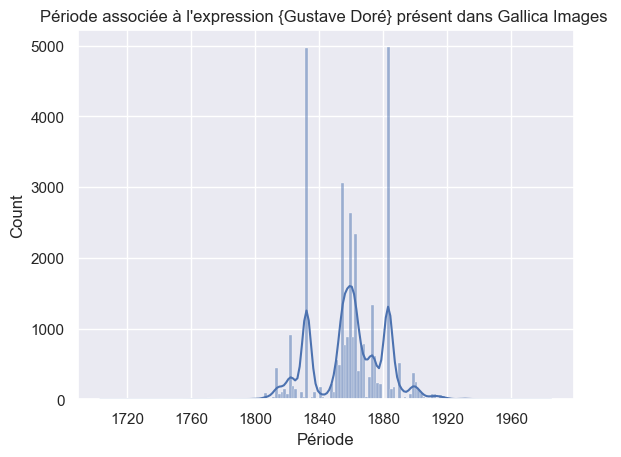

In [7]:
#Histogramme des dates où Gustave Doré est présent sur Gallica 
sns.set(style="darkgrid")
sns.histplot(data=df_n, x="date", kde=True)
plt.title("Période associée à l'expression {Gustave Doré} présent dans Gallica Images ")
plt.xlabel("Période")
plt.show()

In [47]:
'''
Quand on analyse le graphique on remarque que les deux années qui reviennent le plus souvent sont l'année
de naissance et l'année de mort de Gustave Doré (1832-1883). Ce qui semble logique puisque l'expression
'Gustave Doré' doit être le plus souvent associée celle-ci.
Nous allons donc sélectionner les 5 premières date les plus fréquente pour la suite du filtrage
'''
df_n['date'].value_counts().nlargest(5)

1832-01-01    4974
1883-01-01    4939
1855-01-01    2319
1860-01-01    1640
1873-01-01    1339
Name: date, dtype: int64

In [48]:
#Filtre la DataFrame en gardant uniquement les 5 premières dates plus fréquente
df_filtering_date = df_n[df_n['date'].isin(df_n['date'].value_counts().nlargest(5).index.tolist())]
df_filtering_date

,ark,artist,artist_from,date,date_from
0,btv1b105397373,Gustave Doré,title,1832-01-01,creator
0,btv1b105397373,Gustave Doré,title,1883-01-01,creator
4,btv1b10217613z,Gustave Doré,title,1832-01-01,title
4,btv1b10217613z,Gustave Doré,title,1883-01-01,title
6,btv1b531008568,Gustave Doré,title,1883-01-01,subject
...,...,...,...,...,...
14571,btv1b10321052d,Gustave Doré,relation,1883-01-01,creator
14572,btv1b10321052d,Gustave Doré,relation,1855-01-01,relation
14573,btv1b10321052d,Gustave Doré,relation,1855-01-01,date
14574,btv1b9003663t,Gustave Doré,title,1832-01-01,creator


In [49]:
'''
Récupère le DataFrame original et filtre avec les ark qui correspond à la date la plus fréquente
df_filtering_date_max['ark'].tolist() transforme la colonne 'ark' en list()
'''
df_filtering = df[df['ark'].isin(df_filtering_date['ark'].tolist())]
df_filtering

,ark,group,match,from
19911,btv1b105397373,artiste,Gustave Doré,title
19912,btv1b105397373,techniques,Peinture,title
19913,btv1b105397373,date,1832;1883;1820;1910,creator
19914,btv1b105397373,date,1869;1800,subject
19915,btv1b105397373,techniques,Peinture,subject
...,...,...,...,...
7573431,btv1b9003663t,artiste,Gustave Doré,title
7573432,btv1b9003663t,date,1832;1883,creator
7573433,btv1b9003663t,date,1872;1811,subject
7573434,btv1b9003663t,estampe,estampe,type


In [50]:
'''
Combine toutes les méthodes vues précédemment,
afin de récupérer un DataFrame qui recense les techniques les plus fréquentes en lien avec les estampes
'''

#Filtre les estampes
df_est = df_filtering[df_filtering['group'].isin(['estampe'])].copy()
df_est.drop(['group','match'],axis=1, inplace=True)
df_est.rename(columns={'from': 'estampe_from'}, inplace=True)
df_est

#Filtre les techniques
df_tech = df_filtering[df_filtering['group'].isin(['techniques'])].copy()
df_tech.drop(['group'],axis=1, inplace=True)
df_tech.rename(columns={'from': 'techniques_from'}, inplace=True)
df_tech.rename(columns={'match': 'techniques'}, inplace=True)
df_tech

#Jointure entre les tables sur la clée 'ark'
df_jointure2 = pd.merge(df_tech, df_est, on='ark')
df_jointure2['techniques'] = df_jointure2['techniques'].str.split(';')
df_jointure2 = df_jointure2.explode('techniques')
df_jointure2

print(df_jointure2['techniques'].value_counts())
df_jointure2

plume    82
mine      8
huile     2
encre     2
Name: techniques, dtype: int64


,ark,techniques,techniques_from,estampe_from
0,btv1b103200361,mine,title,title
1,btv1b103200361,mine,title,type
2,btv1b103197173,plume,format,title
3,btv1b103197173,plume,format,type
4,btv1b10319720c,plume,format,title
...,...,...,...,...
89,btv1b10319743j,plume,format,type
90,btv1b10319748s,plume,format,title
91,btv1b10319748s,plume,format,type
92,btv1b103205809,plume,format,title


In [52]:
'''
1.Filtre le DataFrame selon la localisation
  1.1 L'estampe doit être présent dans le champs 'type' et 'format'
  1.2 Les techniques doivent être présente dans le champ 'format'
2.Créer une liste de techniques uniques (en fonction du filtrage précédent)
3.Parcours cette liste pour créer un dictionnaire qui rassemble les 'ark' sous les techniques qui sont uniques
'''
technique_ark = {}
filtering_1 = df_jointure2[(df_jointure2['estampe_from'] == 'type') | (df_jointure2['estampe_from'] == 'format')]
filtering_2 = filtering_1[filtering_1['techniques_from'] == 'format']
unique_techniques = filtering_2['techniques'].unique()
for technique in unique_techniques:
    # Filtrage des ARK pour la technique donnée
    arks = filtering_2[filtering_2['techniques'] == technique]['ark'].tolist()
    # Ajouter la technique et la liste d'ARK dans le dictionnaire
    technique_ark[technique] = arks
technique_ark

{'plume': ['btv1b103197173',
  'btv1b10319720c',
  'btv1b103205771',
  'btv1b10319696k',
  'btv1b10320569h',
  'btv1b10319721t',
  'btv1b10319747b',
  'btv1b103205754',
  'btv1b103197423',
  'btv1b10320571b',
  'btv1b103197245',
  'btv1b103205737',
  'btv1b103197228',
  'btv1b103196954',
  'btv1b103205682',
  'btv1b10320583n',
  'btv1b10320565q',
  'btv1b10320579x',
  'btv1b103197190',
  'btv1b10320570w',
  'btv1b10320605m',
  'btv1b10320567m',
  'btv1b10320608z',
  'btv1b10319718j',
  'btv1b10319725m',
  'btv1b10320585j',
  'btv1b10319723q',
  'btv1b103197262',
  'btv1b103205826',
  'btv1b103206045',
  'btv1b10319716n',
  'btv1b103205665',
  'btv1b10320578g',
  'btv1b10320576k',
  'btv1b10320572s',
  'btv1b10320581r',
  'btv1b10320574p',
  'btv1b103197497',
  'btv1b10319743j',
  'btv1b10319748s',
  'btv1b103205809'],
 'encre': ['btv1b10322340k']}

In [53]:
"""
Créer un dictionnaire qui a pour clée un 'ark' 
et pour valeur un tuple (titre, techniques, nombre d'image pour le document)
"""
ark_title_techniques = {ark: (Document(ark).metadata['title'],technique,len(Document(ark).images)) 
                        for technique, ark_list in technique_ark.items() 
                        for ark in ark_list}
ark_title_techniques

{'btv1b103197173': (['[La Vie en province] : [estampe] ([État avant la lettre]) / [Gustave Doré]'],
  'plume',
  1),
 'btv1b10319720c': (['[Promenades aux Tuileries] : [estampe] ([État avant la lettre]) / G. Doré'],
  'plume',
  1),
 'btv1b103205771': (['[Planche de : Doré, Gustave, "Les travaux d\'Hercule"] : [estampe] ([Tiré à part avec la lettre]) / G. Doré'],
  'plume',
  1),
 'btv1b10319696k': (['[Grotesques] : [estampe] ([État avant la lettre]) / G. Doré'],
  'plume',
  1),
 'btv1b10320569h': (['[Planche de : Doré, Gustave, "Les travaux d\'Hercule"] : [estampe] ([Tiré à part avec la lettre]) / G. Doré'],
  'plume',
  1),
 'btv1b10319721t': (['[Les Collégiens] : [estampe] ([État avant la lettre]) / [Gustave Doré]'],
  'plume',
  1),
 'btv1b10319747b': (['[Grotesques] : [estampe] ([État avant la lettre]) / G. Doré'],
  'plume',
  1),
 'btv1b103205754': (['[Planche de : Doré, Gustave, "Les travaux d\'Hercule"] : [estampe] ([Tiré à part avec la lettre]) / G. Doré'],
  'plume',
  1),


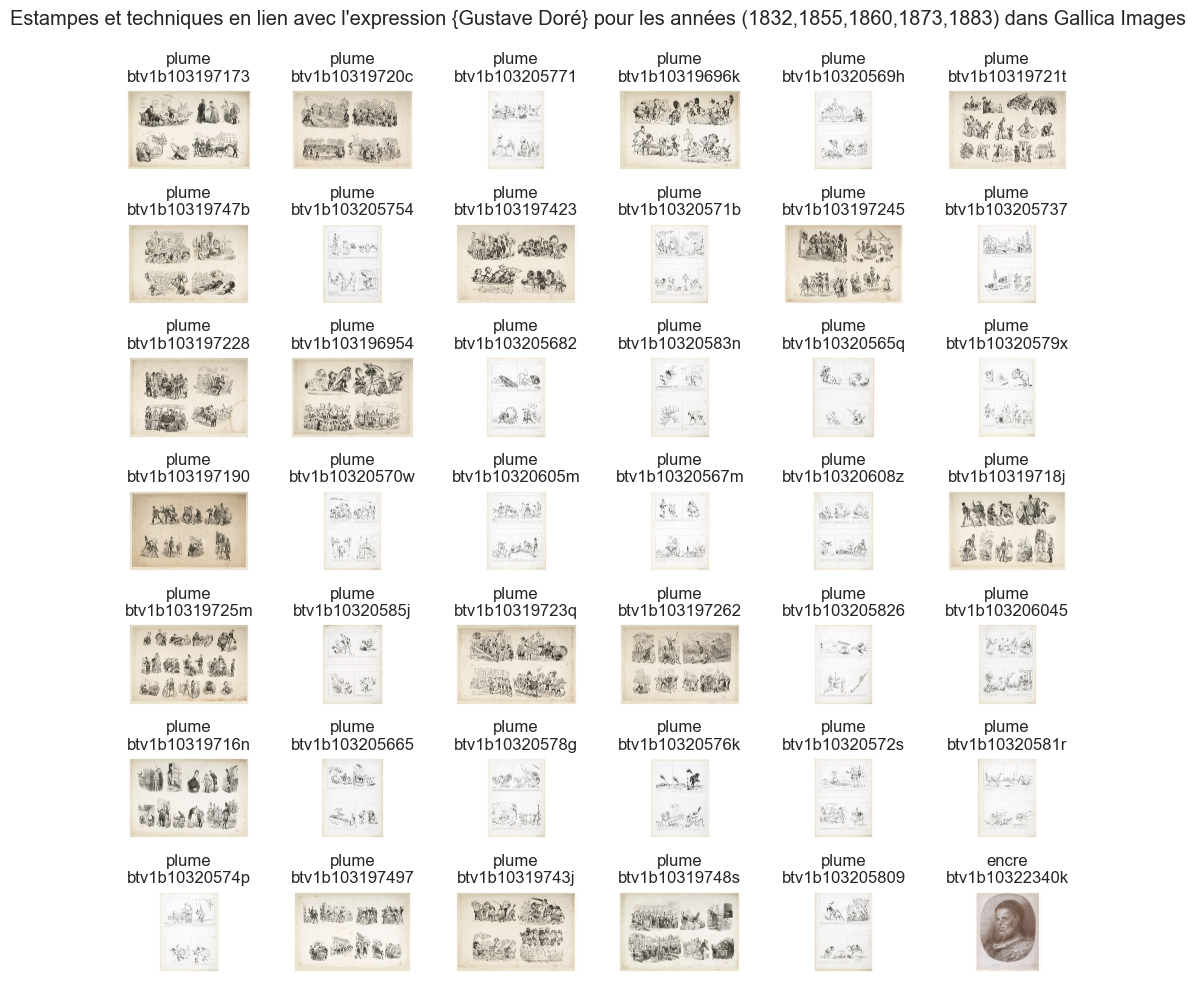

In [55]:
#Prend un certain temps avant de visualiser les résultats (le temps de requêter toutes les images)

scale = 0.2
num_images = len(ark_title_techniques)  # Nombre total d'images

# Calcul du nombre de lignes et de colonnes pour la grille de sous-graphiques
num_rows = int(np.ceil(np.sqrt(num_images)))
num_cols = int(np.ceil(num_images / num_rows))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, (ark, tuples) in enumerate(ark_title_techniques.items()):
    # (tips) IIIF limite le téléchargement répéter d'image dont la taille est supérieur à 50%
    url = Document(ark).images[0].replace('full/full/0/native.jpg','full/pct:30/0/native.jpg')
    img = skimage.io.imread(url)
    img_rgb = skimage.color.gray2rgb(img) if len(img.shape) == 2 else img

    # Ajout de l'image au sous-graphique correspondant
    ax = axes[i // num_cols, i % num_cols]  # Sélection du sous-graphique
    ax.imshow(img_rgb)
    ax.set_title(f'{tuples[1]}\n{ark}')
    ax.set_xticks([])
    ax.set_yticks([])

# Suppression des sous-graphiques vides (s'il en reste)
if num_images < num_rows * num_cols:
    for i in range(num_images, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

# Ajustement automatique des espacements
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Estampes et techniques en lien avec l'expression {Gustave Doré} pour les années (1832,1855,1860,1873,1883) dans Gallica Images")
plt.show()

### Collecte des images via un `.csv`

Il est possible de télécharger l'ensemble des images via un `.csv` exporté avec Pandas. Le module `iiif_from_csv()` dispose également d'un dictionnaire qui attribut des *form* IIIF par défaut à l'instart de [`fetch_image()`](docparams_dft) présent dans la classe `Document` mais également un dictionnaire pour le `leaky_bucket`. La différence avec `fetch_images()` et que ce dernier est rattaché à l'ark qui a été instancié via la classe `Document` contrairement a `iiif_from_csv()` qui permet la collecte d'images appartenant a plusieurs documents.


```{mermaid}
stateDiagram-v2
direction TB

state client_timeout{


concurrents_manifest-->seconds_manifest :window
seconds_manifest-->concurrents_manifest :allows
concurrents_manifest--> get_manifest_timeout : authorize

state get_manifest_timeout{
[*] --> manifest.json
manifest.json  --> get_img_timeout : len(img)
}
	concurrents_img-->seconds_img :window
	seconds_img-->concurrents_img :allows

	concurrents_img--> get_img_timeout : authorize
	
	f(n)/(ark)/(region)/(size)/(rotation)/(quality)/.()extension --> img :chunksize
	
	state get_img_timeout {
	[*] -->f(n)/(ark)/(region)/(size)/(rotation)/(quality)/.()extension
	f(n)/(ark)/(region)/(size)/(rotation)/(quality)/.()extension
	}
}
```

In [56]:
default_img

{'name': '202306121912',
 'image': False,
 'region': 'full',
 'size': 'pct:50',
 'rotation': '0',
 'quality': 'native',
 'extension': 'jpg'}

In [57]:
leaky_bucket_layer

{'concurrents_manifest': 50,
 'seconds_manifest': 60,
 'concurrents_img': 20,
 'seconds_img': 60,
 'chunksize': 1024,
 'client_timeout': 60,
 'get_manifest_timeout': 60,
 'get_img_timeout': 60}

In [58]:
'''
Création d'un dictionnaire vide avec les 'form' du protocole IIIF.
Insère une liste d'ark et des valeurs par défaut.
L'ensemble des documents ne comporte qu'une image nous le savons car chaque tuple dans 'ark_title_techniques' tuples[2] nous renvoit "1"
Nous allons donc remplir la colonne image par 'f1', mais nous aurions très bien pu remplir la colonne par une liste d'images ou bien tout simplement
ne pas la considérer dans le dictionnaire.

Note: il est important de séparer les valeurs présent à l'intérieur d'une cellule par le séparateur ('/').
'''
obj = {
    'ark': list(ark_title_techniques.keys()),
    'name': list(tuples[1] for ark,tuples in ark_title_techniques.items()),
    'image': 'f1',
    'region': 'full',
    'size': 'pct:30',
    'rotation': 0,
    'quality': 'native',
    'extension': 'jpg'
}

#Créer un DataFrame basé sur le dictionnaire
df_iiif = pd.DataFrame(obj)
df_iiif

,ark,name,image,region,size,rotation,quality,extension
0,btv1b103197173,plume,f1,full,pct:30,0,native,jpg
1,btv1b10319720c,plume,f1,full,pct:30,0,native,jpg
2,btv1b103205771,plume,f1,full,pct:30,0,native,jpg
3,btv1b10319696k,plume,f1,full,pct:30,0,native,jpg
4,btv1b10320569h,plume,f1,full,pct:30,0,native,jpg
5,btv1b10319721t,plume,f1,full,pct:30,0,native,jpg
6,btv1b10319747b,plume,f1,full,pct:30,0,native,jpg
7,btv1b103205754,plume,f1,full,pct:30,0,native,jpg
8,btv1b103197423,plume,f1,full,pct:30,0,native,jpg
9,btv1b10320571b,plume,f1,full,pct:30,0,native,jpg


In [59]:
#Créer un csv à partir du DataFrame
df_iiif.to_csv('data/csv/gustave_dore_techniques_from_5topdate.csv',index=False)
#Collecte les images à partir du csv
collecting_images(path='data/csv/gustave_dore_techniques_from_5topdate.csv',directory='./data/img/gustave_dore_from_5topdate/')

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]



  0%|                                                                                            | 0/1 [00:00<?, ?it/s]




  0%|                                                                                            | 0/1 [00:00<?, ?it/s]





  0%|                                                                                            | 0/1 [00:00<?, ?it/s]






  0%|                                                                                            | 0/1 [00:00<?, ?it/s]







  0%|                                                                                            | 0/1 [00:00<?, ?it/s]








  0%

In [60]:
#Imaginons qu'un document contient un ensemble d'images et que nous aimerions récupérer des images en particulier
#Ici nous créons une fonction qui prend un 'ark' comme argument et retourne un nombre aléatoire d'images (la moitié des images que le document dispose)
random_images = lambda ark: '/'.join(random.sample([f'f{i}' for i in range(1,len(Document(ark).images)+1)],len(Document(ark).images) // 2 
                                          if len(Document(ark).images) > 1 else len(Document(ark).images)))

In [61]:
#Ici un document qui contient plusieurs images
Document('bpt6k62463369').images

['https://gallica.bnf.fr/iiif/ark:/12148/bpt6k62463369/f1/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/bpt6k62463369/f2/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/bpt6k62463369/f3/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/bpt6k62463369/f4/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/bpt6k62463369/f5/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/bpt6k62463369/f6/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/bpt6k62463369/f7/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/bpt6k62463369/f8/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/bpt6k62463369/f9/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/bpt6k62463369/f10/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/bpt6k62463369/f11/full/full/0/native.jpg',
 'https://gallica.bnf.fr/iiif/ark:/12148/bpt6k62463369/f12/full/full/0/native.jpg',
 

(namefordoc)=

In [40]:
#Regex et built_in fonction pour normaliser le titre du document
name = re.sub(r'[^\w\s]+','_', Document('bpt6k62463369').metadata['title'][0].lower().replace(' ','')) 
obj = {
    'ark': 'bpt6k62463369',
    'name': name,
    'image': False,
    'region': 'full',
    'size': 'pct:30',
    'rotation': 0,
    'quality': 'native',
    'extension': 'jpg'
}
print(obj)

{'ark': 'bpt6k62463369', 'name': 'lerire_journalhumoristique', 'image': False, 'region': 'full', 'size': 'pct:30', 'rotation': 0, 'quality': 'native', 'extension': 'jpg'}


In [41]:
'''
Ici la chose importante à remarquer est que le séparateur de champs est ('/').
Il est possible de passer également un ensemble de valeurs pour les autres colonnes à condition que leurs nombres soient tous égaux entre eux.
'''
df_iiif2 = pd.DataFrame([obj], index=[0])
df_iiif2['image'] = random_images('bpt6k62463369')
df_iiif2

,ark,name,image,region,size,rotation,quality,extension
0,bpt6k62463369,lerire_journalhumoristique,f1/f5/f16/f2/f15/f4/f13/f6,full,pct:30,0,native,jpg


In [42]:
#Créer un csv à partir du DataFrame
df_iiif2.to_csv('data/csv/lerire_journalhumoristique.csv',index=False)
#Collecte les images à partir du csv
collecting_images(path='data/csv/lerire_journalhumoristique.csv',directory='./data/img/lerire_journalhumoristique')

100%|██████████████████████████| 8/8 [00:01<00:00,  4.80it/s]
